In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image

input_root = r"C:\dataset"
for class_folder in os.listdir(input_root):
    class_path = os.path.join(input_root, class_folder)
    for fname in os.listdir(class_path):
        if fname.lower().endswith('.gif'):
            gif_path = os.path.join(class_path, fname)
            png_path = os.path.join(class_path, fname[:-4] + '.png')
            with Image.open(gif_path) as im:
                im.convert('RGB').save(png_path)
            print(f"Converted {gif_path} to {png_path}")

In [ ]:
import os
import cv2

input_root = r"C:\dataset"
output_root = r"C:\dataset_patches"
patch_size = 160
stride = 160
expected_size = 640

os.makedirs(output_root, exist_ok=True)

for class_folder in os.listdir(input_root):
    class_in = os.path.join(input_root, class_folder)
    class_out = os.path.join(output_root, class_folder)
    os.makedirs(class_out, exist_ok=True)

    for fname in os.listdir(class_in):
        if not fname.lower().endswith('.png'):
            continue

        img_path = os.path.join(class_in, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"WARNING: Could not load image {img_path}")
            continue

        img = cv2.resize(img, (expected_size, expected_size))

        h, w = img.shape
        count = 0
        for y in range(0, h - patch_size + 1, stride):
            for x in range(0, w - patch_size + 1, stride):
                patch = img[y:y+patch_size, x:x+patch_size]
                outname = os.path.join(class_out, f"{fname[:-4]}_patch{count}.png")
                cv2.imwrite(outname, patch)
                count += 1
        print(f"{class_folder}: {count} patches created from {fname}")

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
PATCH_SIZE = 3
IHVG_BINS = 32
PCA_COMPONENTS = 0.95

In [ ]:
def compute_ihvg_degree_features(img, bins=IHVG_BINS):
    h, w = img.shape
    degree_map = np.zeros((h, w), dtype=int)

    for i in range(h):
        for j in range(w):
            current = img[i, j]
            for k in range(j - 1, -1, -1):
                if img[i, k] > current:
                    break
                degree_map[i, j] += 1
            for k in range(j + 1, w):
                if img[i, k] > current:
                    break
                degree_map[i, j] += 1
    for j in range(w):
        for i in range(h):
            current = img[i, j]
            for k in range(i - 1, -1, -1):
                if img[k, j] > current:
                    break
                degree_map[i, j] += 1
            for k in range(i + 1, h):
                if img[k, j] > current:
                    break
                degree_map[i, j] += 1

    hist, _ = np.histogram(degree_map, bins=bins, range=(0, bins), density=True)
    return hist

In [ ]:
def detect_motif_vg(x0, x1, x2):
    return 0 if x1 >= min(x0, x2) else 1

In [ ]:
def compute_patch_motifs(patch):
    assert patch.shape == (3, 3)
    motifs = []

    for i in range(3):
        x0, x1, x2 = patch[i, 0], patch[i, 1], patch[i, 2]
        motifs.append(detect_motif_vg(x0, x1, x2))

    for j in range(3):
        x0, x1, x2 = patch[0, j], patch[1, j], patch[2, j]
        motifs.append(detect_motif_vg(x0, x1, x2))

    x0, x1, x2 = patch[0, 0], patch[1, 1], patch[2, 2]
    motifs.append(detect_motif_vg(x0, x1, x2))

    x0, x1, x2 = patch[0, 2], patch[1, 1], patch[2, 0]
    motifs.append(detect_motif_vg(x0, x1, x2))

    return motifs

In [ ]:
def patch_label_from_motifs(motifs):
    label = 0
    for i, m in enumerate(motifs):
        label |= (m << i)
    return label

In [ ]:
def patch_profile_ivg(img, patch_size=PATCH_SIZE):
    h, w = img.shape
    Z = np.zeros(256)
    for i in range(h - patch_size + 1):
        for j in range(w - patch_size + 1):
            patch = img[i:i+patch_size, j:j+patch_size]
            motifs = compute_patch_motifs(patch)
            label = patch_label_from_motifs(motifs)
            Z[label] += 1
    return Z / Z.sum() if Z.sum() > 0 else Z

In [ ]:
def load_images_and_labels(folder_path):
    X, y, paths = [], [], []
    for class_folder in sorted(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        label = class_folder.split('_')[-1]

        for filename in sorted(os.listdir(class_path)):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"WARNING: Could not read {img_path}")
                    continue

                img = cv2.resize(img, (160, 160))

                global_feat = compute_ihvg_degree_features(img)
                local_feat = patch_profile_ivg(img)
                feat = np.concatenate([global_feat, local_feat])
                X.append(feat)
                y.append(label)
                paths.append(img_path)
    return np.array(X), np.array(y), np.array(paths)

In [ ]:
def display_predictions(image_paths, true_labels, predicted_labels, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(image_paths))):
        img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (160, 160))
        plt.subplot(2, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Feature shape: (400, 288)
Labels shape: (400,)
Test Accuracy: 0.9833


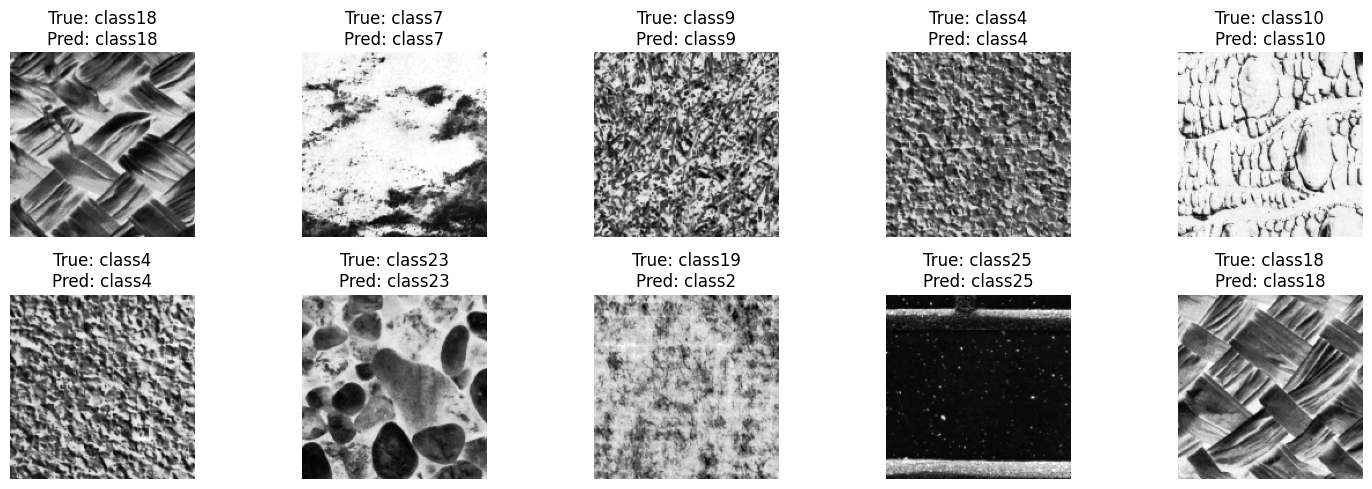

In [ ]:
folder_path = '/content/drive/MyDrive/dataset_patches'
X, y, paths = load_images_and_labels(folder_path)

print(f"Feature shape: {X.shape}")
print(f"Labels shape: {y.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X_pca, y, paths, test_size=0.3, stratify=y, random_state=42)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

display_predictions(paths_test, y_test, y_pred, num_samples=10)
